# Evaluation of Simulation Models

This notebook studies various properties of the simulation models used in `covid19 outbreak simulator`.

In [ ]:
from matplotlib import pyplot
import numpy as np
import pandas as pd
import os

from argparse import Namespace
from covid19_outbreak_simulator.model import Model, Params
from covid19_outbreak_simulator.population import Individual

params = Params(
    Namespace(
        interval=1/24,
        popsize=['64'],
        infectors=[],
        symptomatic_r0=None,
        asymptomatic_r0=None,
        incubation_period=None,
        susceptibility=None,
        prop_asym_carriers=None,
        symptomatic_transmissibility_model = ['piecewise'],
        asymptomatic_transmissibility_model = ['piecewise'],
    )
)
model = Model(params)

## Distribution of asymptomatic carriers

In [2]:
avg_asym_carriers = 0
N = 1000
for i in range(N):
    model.draw_prop_asym_carriers()
    avg_asym_carriers += sum([model.draw_is_asymptomatic() for i in range(1000)])/1000

avg_asym_carriers /= N

print(f'Average asymptomatic carriers is {avg_asym_carriers * 100:.2f}%')
    

Average asymptomatic carriers is 24.98%


## Distribution of incubation period

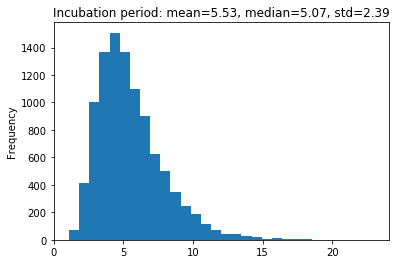

In [3]:
model.params.set('prop_asym_carriers', 'loc', 0)
model.params.set('prop_asym_carriers', 'scale', 0)

ips = pd.Series([model.draw_random_incubation_period() for x in range(10000)])

ips.plot(kind='hist', bins=30, 
         title=f'Incubation period: mean={ips.mean():.2f}, median={ips.median():.2f}, std={ips.std():.2f}')

## Distribution of production number

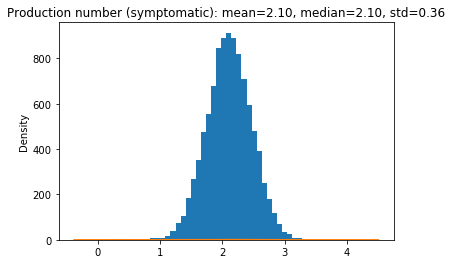

In [4]:
# thoretical distribution

sr0 = pd.Series([model.draw_random_r0(symptomatic=True) for x in range(10000)])
sr0.plot.hist( bins=30,
         title=f'Production number (symptomatic): mean={sr0.mean():.2f}, median={sr0.median():.2f}, std={sr0.std():.2f}')
sr0.plot.density()

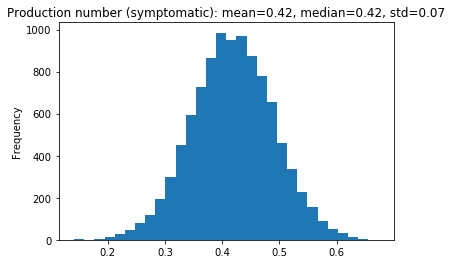

In [5]:

asr0 = pd.Series([model.draw_random_r0(symptomatic=False) for x in range(10000)])
asr0.plot.hist( bins=30,
         title=f'Production number (symptomatic): mean={asr0.mean():.2f}, median={asr0.median():.2f}, std={asr0.std():.2f}')


## Observed production number

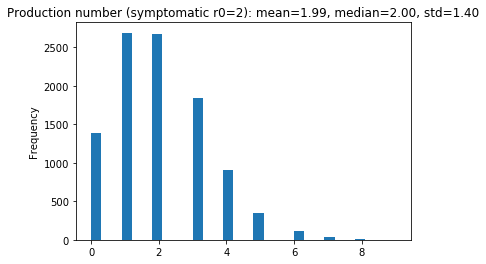

In [6]:
import os

model.params.set('prop_asym_carriers', 'loc', 0)
model.params.set('prop_asym_carriers', 'scale', 0)

infections = []
r0 = []
with open(os.devnull, 'w') as logger:
    logger.id = 1
    model.draw_prop_asym_carriers()
    model.params.set('symptomatic_r0', 'loc', 2)
    model.params.set('symptomatic_r0', 'scale', 0)
    for i in range(10000):
        ind = Individual(id='0', susceptibility=1, model=model, logger=logger)
        evts = ind.symptomatic_infect(time=0, by=None,
                                     handle_symptomatic=['keep'])
        r0.append(ind.r0)
        # print(', '.join(x.action.name for x in evts))
        infect_evts = [evt for evt in evts if evt.action.name == 'INFECTION']
        infections.append(len(infect_evts))

ifn = pd.Series(infections)
ifn.plot.hist( bins=30,
         title=f'Production number (symptomatic r0=2): mean={ifn.mean():.2f}, median={ifn.median():.2f}, std={ifn.std():.2f}')

#sr0 = pd.Series(r0)
#sr0.plot.hist()


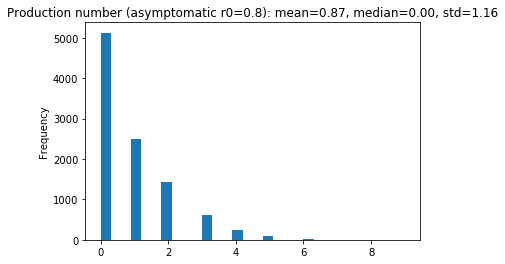

In [7]:
import os

model.params.set('prop_asym_carriers', 'loc', 1.0)
model.params.set('prop_asym_carriers', 'scale', 0)

infections = []
r0 = []
with open(os.devnull, 'w') as logger:
    logger.id = 1
    model.draw_prop_asym_carriers()
    model.params.set('asymptomatic_r0', 'loc', 0.8)
    model.params.set('asymptomatic_r0', 'scale', 0.8)    
    for i in range(10000):
        ind = Individual(id='0', susceptibility=1, model=model, logger=logger)
        evts = ind.asymptomatic_infect(time=0, by=None,
                                     handle_symptomatic=['keep'])
        r0.append(ind.r0)
        # print(', '.join(x.action.name for x in evts))
        infect_evts = [evt for evt in evts if evt.action.name == 'INFECTION']
        infections.append(len(infect_evts))

ifn = pd.Series(infections)
ifn.plot.hist( bins=30,
         title=f'Production number (asymptomatic r0=0.8): mean={ifn.mean():.2f}, median={ifn.median():.2f}, std={ifn.std():.2f}')

#asr0 = pd.Series(r0)
#asr0.plot.hist()


### Communicable period 

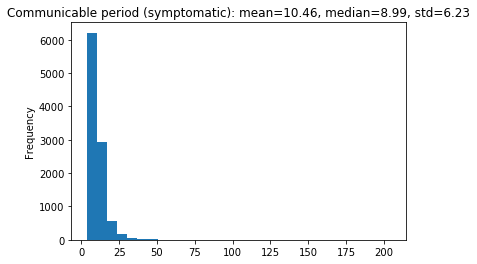

In [10]:
model.params.set('prop_asym_carriers', 'loc', 0)
model.params.set('prop_asym_carriers', 'scale', 0)

infections = []
cp = []
with open(os.devnull, 'w') as logger:
    logger.id = 1
    model.draw_prop_asym_carriers()
    model.params.set('symptomatic_r0', 'loc', 2.1)
    model.params.set('symptomatic_r0', 'quantile_2.5', 1.4)
    for i in range(10000):
        ind = Individual(id='0', susceptibility=1, model=model, logger=logger)
        evts = ind.symptomatic_infect(time=0, by=None,
                                     handle_symptomatic=['keep'])
        cp.append(ind.infect_params[3] - ind.infect_params[1])

cp = pd.Series(cp)
cp.plot.hist( bins=30,
         title=f'Communicable period (symptomatic): mean={cp.mean():.2f}, median={cp.median():.2f}, std={cp.std():.2f}')


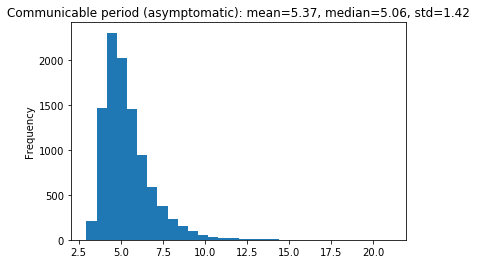

In [11]:
model.params.set('prop_asym_carriers', 'loc', 1)
model.params.set('prop_asym_carriers', 'scale', 0)

infections = []
acp = []
with open(os.devnull, 'w') as logger:
    logger.id = 1
    model.draw_prop_asym_carriers()
    model.params.set('asymptomatic_r0', 'loc', 2.1/5)
    model.params.set('asymptomatic_r0', 'quantile_2.5', 1.4/5)
    for i in range(10000):
        ind = Individual(id='0', susceptibility=1, model=model, logger=logger)
        evts = ind.asymptomatic_infect(time=0, by=None,
                                     handle_symptomatic=['keep'])
        acp.append(ind.infect_params[3] - ind.infect_params[1])

acp = pd.Series(acp)
acp.plot.hist( bins=30,
         title=f'Communicable period (asymptomatic): mean={acp.mean():.2f}, median={acp.median():.2f}, std={acp.std():.2f}')


## Transmissibility curve



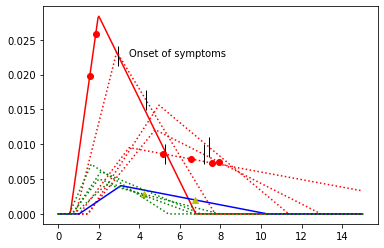

In [12]:
import os
import matplotlib.pyplot as plt

model.params.set('prop_asym_carriers', 'loc', 0)
model.params.set('prop_asym_carriers', 'scale', 0)

infections = []
r0 = []

with open(os.devnull, 'w') as logger:
    logger.id = 1
    model.draw_prop_asym_carriers()
    for i in range(5):
        ind = Individual(id='0', susceptibility=1, model=model, logger=logger)
        evts = ind.symptomatic_infect(time=0, by=None,
                                     handle_symptomatic=['keep'])
        x = np.linspace(0, 15, 15*24)
        #y = [ind.viral_load(t) for t in x]
        #plt.plot(x,y, linestyle=':' if i > 0 else '-', color='red')
        #
        y = [ind.transmissibility(t) for t in x]
        plt.plot(x,y, linestyle=':' if i > 0 else '-', color='red' if i == 0 else 'red' )

        # incubation
        plt.plot(ind.incubation_period, ind.transmissibility(ind.incubation_period),
                color='black', markersize=20, marker='|')
        if i == 0:
            plt.text( ind.incubation_period + 0.5, ind.transmissibility(ind.incubation_period),
                    'Onset of symptoms')        
        # infection event
        it = [x.time for x in evts if x.action.name == 'INFECTION']
        ity = [ind.transmissibility(t) for t in it]
        plt.plot(it, ity, 'o', color='red')
        
model.params.set('prop_asym_carriers', 'loc', 1)
model.params.set('prop_asym_carriers', 'scale', 0)

infections = []
r0 = []

with open(os.devnull, 'w') as logger:
    logger.id = 1
    model.draw_prop_asym_carriers()
    for i in range(5):
        ind = Individual(id='0', susceptibility=1, model=model, logger=logger)
        evts = ind.asymptomatic_infect(time=0, by=None,
                                     handle_symptomatic=['keep'])
        x = np.linspace(0, 15, 15*24)
        y = [ind.transmissibility(t) for t in x]
        plt.plot(x,y, linestyle=':' if i > 0 else '-', color='blue' if i == 0 else 'green' )
        
        #
        it = [x.time for x in evts if x.action.name == 'INFECTION']
        ity = [ind.transmissibility(t) for t in it]
        plt.plot(it, ity, 'y^' if i == 0 else 'y^')
        
plt.show()
                

## Test sensibility



In [13]:
from covid19_outbreak_simulator.cli import main

main('''--popsize 5000 --rep 1
    --symptomatic-transmissibility-model piecewise
    --asymptomatic-transmissibility-model piecewise
    --handle-symptomatic keep
    --stop-if t>14   --track-events PLUGIN END   
    --logfile test.log   --plugin init --incidence-rate 1  --leadtime any 
    --plugin quarantine --at 0 --duration 14 --target all --proportion 1   
    --plugin testing   --interval 1 --proportion 1
    --turnaround-time 0
    --handle-positive keep --sensitivity 0.9 0.0002  --specificity 1
  '''.split())

100%|##########| 1/1 [00:23<00:00, 23.80s/it]


logfile	test.log
popsize	5000
handle_symptomatic	keep
interval	1 hour
prop_asym_carriers	10% to 40%
leadtime	no
n_simulation	1
total_infection	0
total_infection_failed	0
total_infection_avoided	0
total_infection_ignored	0
total_show_symptom	0
total_removal	0
total_recover	0
total_quarantine	0
total_reintegration	0
total_abort	0
total_asym_infection	0
total_presym_infection	0
total_sym_infection	0
n_remaining_popsize_5000	1
n_no_outbreak	0
n_outbreak_duration_16	1
n_no_infected_by_seed	1
n_seed_show_no_symptom	1
n_no_first_infection	1
n_first_symptom	0
n_second_symptom	0
n_third_symptom	0
plugin_name_0.00	init, testing
plugin_name_1.00	testing
plugin_name_2.00	testing
plugin_name_3.00	testing
plugin_name_4.00	testing
plugin_name_5.00	testing
plugin_name_6.00	testing
plugin_name_7.00	testing
plugin_name_8.00	testing
plugin_name_9.00	testing
plugin_name_10.00	testing
plugin_name_11.00	testing
plugin_name_12.00	testing
plugin_name_13.00	testing
plugin_name_14.00	testing
plugin_n_recovered_

0

In [63]:
import pandas as pd

res = pd.read_csv('test.log', sep='\t')
res = res[(res['event'] == 'PLUGIN') & res['params'].str.startswith('name=testing')]

In [64]:
def get_test_stats(params):
    n_infected = params.split('n_infected=')[1].split(',')[0]
    n_uninfected = params.split('n_uninfected=')[1].split(',')[0]
    n_recovered = params.split('n_recovered=')[1].split(',')[0]    
    n_false_negative = params.split('n_false_negative=')[1].split(',')[0]
    return n_infected, n_uninfected, n_recovered, n_false_negative

res['params'].apply(get_test_stats)

2         (5000, 0, 0, 747)
3       (4430, 0, 570, 499)
4      (3869, 0, 1131, 538)
5      (3293, 0, 1707, 499)
6      (2740, 0, 2260, 500)
7      (2246, 0, 2754, 521)
8      (1750, 0, 3250, 634)
9      (1385, 0, 3615, 822)
10    (1063, 0, 3937, 1030)
11     (758, 0, 4242, 1234)
12     (523, 0, 4477, 1485)
13     (344, 0, 4656, 1740)
14     (232, 0, 4768, 2066)
15     (158, 0, 4842, 2325)
16     (104, 0, 4896, 2594)
Name: params, dtype: object

In [34]:
res

,id,time,event,target,params


## Serial Interval 

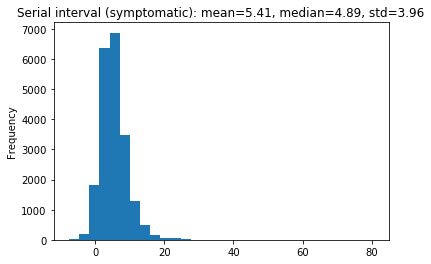

In [15]:
model.params.set('prop_asym_carriers', 'loc', 0)
model.params.set('prop_asym_carriers', 'scale', 0)

si = []
gt = []

with open(os.devnull, 'w') as logger:
    logger.id = 1
    model.draw_prop_asym_carriers()
    for i in range(10000):
        ind = Individual(id='0', susceptibility=1, model=model, logger=logger)
        evts = ind.symptomatic_infect(time=0, by=None,
                                     handle_symptomatic=['keep'])
        for evt in [x for x in evts if x.action.name == 'INFECTION']:
            gt.append(evt.time)
            si.append(evt.time + ind.model.draw_random_incubation_period() - ind.incubation_period)

si = pd.Series(si)
si.plot.hist( bins=30,
         title=f'Serial interval (symptomatic): mean={si.mean():.2f}, median={si.median():.2f}, std={si.std():.2f}')


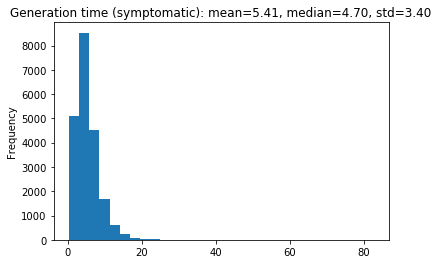

In [17]:
gt = pd.Series(gt)
gt.plot.hist( bins=30,
         title=f'Generation time (symptomatic): mean={gt.mean():.2f}, median={gt.median():.2f}, std={gt.std():.2f}')


In [ ]:
all_r0 = []
all_r = []
all_r_asym = []
all_r_presym = []
all_r_sym = []

In [ ]:
N = 100000

P_asym = 0.25

N_asymptomatic = int(N*P_asym)
N_regular = N - N_asymptomatic

incubation_period = np.concatenate([rand_incu(size=N_regular), np.full(N_asymptomatic, -1)])
R0 =  np.concatenate([np.random.uniform(1.4, 2.8, size=N_regular),
                      np.random.uniform(1.4/5, 2.8/5, size=N_asymptomatic)])


all_r0 = []
all_r = []
all_r_asym = []
all_r_presym = []
all_r_sym = []
all_si = []
all_gt = []
for incu, r0 in zip(incubation_period, R0):
    all_r0.append(f'{round(r0, 1):.1f}')
    r, r_asym, r_presym, r_sym, si, gt = Infect(incu, r0)
    all_r.append(r)
    all_r_asym.append(r_asym)
    all_r_presym.append(r_presym)
    all_r_sym.append(r_sym)
    all_si.append(si)
    all_gt.append(gt)